In [13]:
import tensorflow as tf


dataset_path = r"C:\Users\HBLinks\anaconda3\envs\MLLAB\APPLE_DISEASE_DATASET"

# === Basic settings ===
batch_size = 32
img_size = (64, 64)  # Small size for weak systems

# === Load training and validation datasets ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    color_mode="rgb",       # Assuming colored images
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    color_mode="rgb",
    batch_size=batch_size
)

# === Normalize images to [0, 1] ===
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# === Optional: Improve performance with prefetching ===
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 419 files belonging to 4 classes.
Using 336 files for training.
Found 419 files belonging to 4 classes.
Using 83 files for validation.


In [14]:
from tensorflow.keras import layers

# Define a simple residual block
def res_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if shape mismatch (e.g., when downsampling)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut (skip connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


In [15]:
from tensorflow.keras import models

# Input shape matches your resized images
input_shape = (64, 64, 3)

def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(32, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks (lightweight for weak systems)
    x = res_block(x, 32)
    x = res_block(x, 64, stride=2)
    x = res_block(x, 64)

    # Global average pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [16]:
# 3 classes: Early blight, Healthy, Late blight
num_classes = 4
model = build_resnet(input_shape, num_classes)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 32)        │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 64, 64, 32)        │             128 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_7 (ReLU)                │ (None, 64, 64, 32)        │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ re_lu_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 64, 64, 32)        │             128 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_8 (ReLU)                │ (None, 64, 64, 32)        │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 64, 64, 32)        │           9,248 │ re_lu_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 64, 64, 32)        │             128 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 64, 64, 32)        │               0 │ batch_normalization_10[0]… │
│                               │                           │                 │ re_lu_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_9 (ReLU)                │ (None, 64, 64, 32)        │               0 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 32, 32, 64)        │          18,496 │ re_lu_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 32, 32, 64)        │             256 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_10 (ReLU)               │ (None, 32, 32, 64)        │               0 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 32, 32, 64)        │          36,92

 Total params: 152,708 (596.52 KB)

 Trainable params: 151,876 (593.27 KB)

 Non-trainable params: 832 (3.25 KB)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set path to your dataset
dataset_path = r"C:\Users\HBLinks\anaconda3\envs\MLLAB\APPLE_DISEASE_DATASET"


In [18]:
# Rescale pixel values and do basic augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% for training, 20% for validation
)

# Train loader
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

# Validation loader
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 337 images belonging to 4 classes.
Found 82 images belonging to 4 classes.


In [19]:
print("Class Labels:", train_generator.class_indices)


Class Labels: {'APPLE ROT LEAVES': 0, 'HEALTHY LEAVES': 1, 'LEAF BLOTCH': 2, 'SCAB LEAVES': 3}


In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [21]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5 # You can reduce to 5 if training is slow
)


Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 963ms/step - accuracy: 0.3851 - loss: 1.3744 - val_accuracy: 0.1098 - val_loss: 1.5249
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 819ms/step - accuracy: 0.5514 - loss: 1.0125 - val_accuracy: 0.3171 - val_loss: 1.3500
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 858ms/step - accuracy: 0.5845 - loss: 0.8644 - val_accuracy: 0.3780 - val_loss: 1.3361
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step - accuracy: 0.6240 - loss: 0.8354 - val_accuracy: 0.3780 - val_loss: 1.3813
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 891ms/step - accuracy: 0.5763 - loss: 0.8184 - val_accuracy: 0.3780 - val_loss: 1.5001


In [30]:

model.save('my_model.keras')

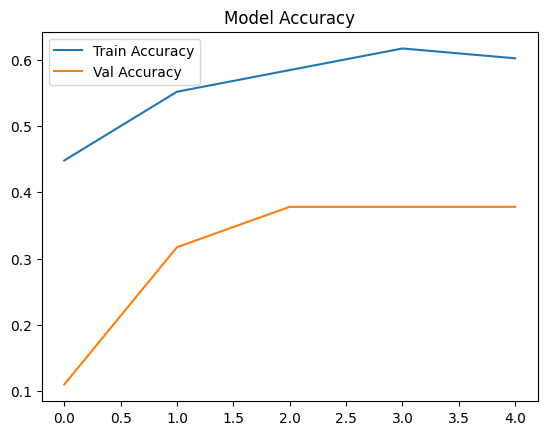

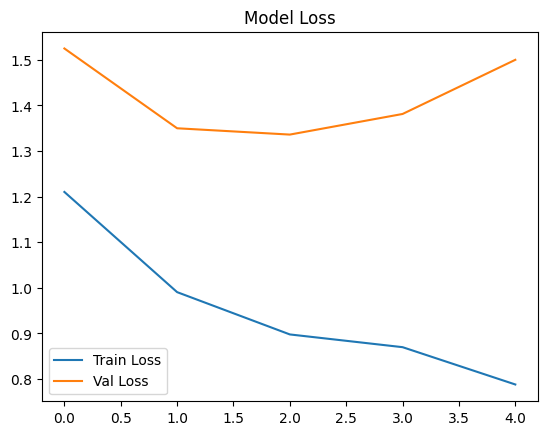

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [24]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.3843 - loss: 1.4495
Validation Accuracy: 37.80%


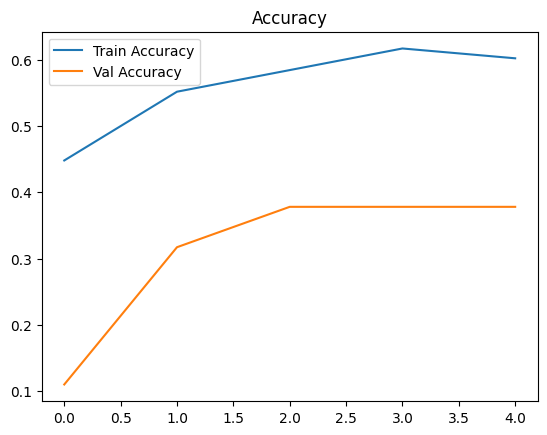

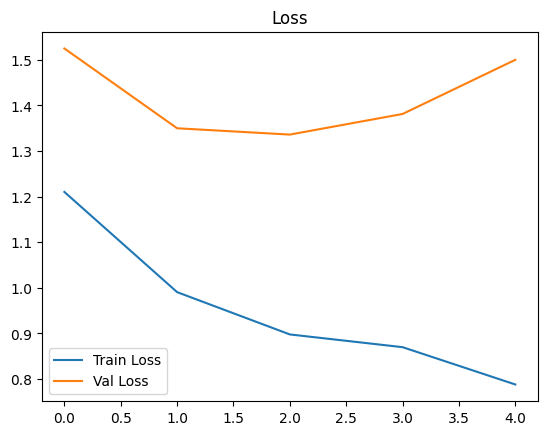

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [28]:
model.save('my_model.keras')


In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\HBLinks\anaconda3\envs\MLLAB\APPLE_DISEASE_DATASET\HEALTHY LEAVES\1.jpg"
img = image.load_img(img_path, target_size=(64, 64))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
class_index = np.argmax(prediction[0])
print(f"Predicted Class: {class_index}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HBLinks\\anaconda3\\envs\\MLLAB\\APPLE_DISEASE_DATASET\\HEALTHY LEAVES\\1.jpg'